# Лабораторная работа №2.1: Обработка признаков 

Выбрать набор данных (датасет), содержащий категориальные и числовые признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.) 

Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
устранение пропусков в данных;
кодирование категориальных признаков;
нормализация числовых признаков.

[![Kaggle link](https://img.shields.io/badge/выбранный%20датасет-Открыть-orange?style=social&logo=kaggle)](https://www.kaggle.com/datasets/leomartinelli/bullying-in-schools)

[![Задание](https://img.shields.io/badge/%D1%81%D1%81%D1%8B%D0%BB%D0%BA%D0%B0-%D0%BD%D0%B0%20%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5-white?style=plastic&logo=github)](https://github.com/ugapanyuk/courses_current/wiki/LAB_MMO__FEATURES)


## §1. Настройки и зависимости

In [3]:
datasets_csv_path = '/Users/blacksnow/github/des-maschinellen-lernens/datasets'

In [47]:
import pandas as pd
import pandas.io.sql as psql
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import plotly.express as px
%matplotlib inline 

## §2. Описание выбранного датасета

In [17]:
bullying_df = pd.read_csv(f'{datasets_csv_path}/Bullying_2018_RAW.csv') 

In [34]:
df_features_ru_desc = np.array([
    ['Номер ответа','-'],
    ['В школе (за последние 12 месяцев)','Категориальный'], 
    ['Вне школы (за последние 12 месяцев)','Категориальный'], 
    ['Кибербуллинг (последние 12 месяцев?)','Категориальный'],
    ['Возраст респондента','Числовой'], 
    ['Пол респондента','Категориальный'], 
    ['Количество физических атак','Числовой'],
    ['Количество драк','Числовой'], 
    ['Ощущение одинокости','Категориальный'], 
    ['Количество близких друзей','Числовой'], 
    ['Количество дней пропусков школы без разрешения','Числовой'], 
    ['Доброта и отзывчивость окружающих','Категориальный'], 
    ['Частота проблем взаимопонимания с родителями','Категориальный'], 
    ['Ощущение одинокости большую части (частота)','Категориальный'],
    ['Пропускали ли вы школу без разрешения (да/нет)','Категориальный'], 
    ['Масса вашего тела в школе была ниже нормы?','Категориальный'],
    ['Масса вашего тела в школе была выше нормы?','Категориальный'], 
    ['Вы страдали ожирением?','Категориальный'], 
]).transpose()



In [36]:
def analyze(df=bullying_df):
    table_headers = ['Название столбца','Описание','Тип признака','Процент пропусков','Кол-во ункиальных значений']
    table = np.empty([5,len(df.columns)],dtype=np.dtype(object))
    table[0]= [col for col in tqdm(df.columns)]
    table[1]=df_features_ru_desc[0]
    table[2]=df_features_ru_desc[1]
    table[3]=[df[col].isna().sum()/df[col].notna().sum() for col in tqdm(df.columns)]
    table[4]=[df[col].nunique() for col in tqdm(df.columns)]

    table = table.transpose()
    print(tabulate(table,tablefmt='github',headers=table_headers))
    df_stats = pd.DataFrame(table,columns=table_headers)
    fig = px.bar(
        df_stats, 
        x="Описание", 
        y='Процент пропусков',
        color="Тип признака",
        title="Процент пропусков в датасете (ответы на вопросы)",
    )
    fig.update_yaxes(range=[0,1])
    fig.show()

analyze()

100%|██████████| 18/18 [00:00<00:00, 603.24it/s]

| Название столбца                                 | Описание                                       | Тип признака   |   Процент пропусков |   Кол-во ункиальных значений |
|--------------------------------------------------|------------------------------------------------|----------------|---------------------|------------------------------|
| record                                           | Номер ответа                                   | -              |          0          |                        56981 |
| Bullied_on_school_property_in_past_12_months     | В школе (за последние 12 месяцев)              | Категориальный |          0.0222274  |                            2 |
| Bullied_not_on_school_property_in_past_12_months | Вне школы (за последние 12 месяцев)            | Категориальный |          0.00865609 |                            2 |
| Cyber_bullied_in_past_12_months                  | Кибербуллинг (последние 12 месяцев?)           | Категориальный |          0.0101223  |

In [48]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

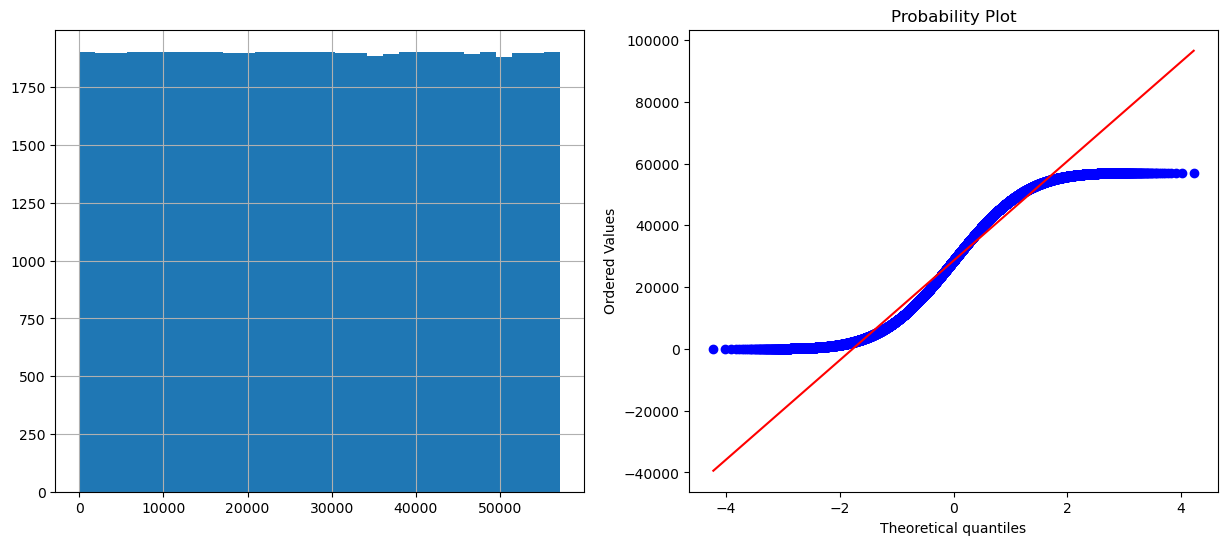

In [53]:
diagnostic_plots(bullying_df, 'record')

## §3. Нормализация числового признака "Количество близких друзей"

Так как пропусков в 

```python
bullying_df["Close_friends"]
```

±2% их возможно качественно заполнить

In [45]:
px.histogram(bullying_df["Close_friends"])

In [74]:
bullying_df_clean = bullying_df.copy()

y_or_n_count = bullying_df_clean['Bullied_not_on_school_property_in_past_12_months'].isin(['Yes','No']).count()
total_count = bullying_df_clean['Bullied_not_on_school_property_in_past_12_months'].count()

total_count-y_or_n_count

0

## §4. Статистика по датасету

In [75]:

def stats(data=bullying_df, desc=bull_desc, headers=('Номер','Название','Описание','Кат.','Числ.','Кол-во вариаций')):
    headers=('Номер','dtype','Описание','Тип','Кол-во пропусков','Кол-во вариаций')
    table = np.arange(data.shape[1]*len(headers))
    table = table.reshape(len(headers),data.shape[1])

    table = np.array([
                [x for x in range(1,19)],
                [d for d in data.dtypes],
                [a[0] for a in desc],
                [a[1] for a in desc],
                [data[col].isna().sum() for col in data.columns],
                [data[col].nunique() for col in data.columns]])

    table = table.transpose()

    print(
        tabulate(
            [data.shape],
            headers=('Кол-во строк', 'Кол-во столбцов'),
            tablefmt="github"),
        end='\n\n\n'
        )
    
    print(
        tabulate(
            table,
            headers=headers,
            tablefmt='github'
        ),
        end='\n\n\n'
        )

stats()

|   Кол-во строк |   Кол-во столбцов |
|----------------|-------------------|
|          56981 |                18 |


|   Номер | dtype   | Описание                                       | Тип            |   Кол-во пропусков |   Кол-во вариаций |
|---------|---------|------------------------------------------------|----------------|--------------------|-------------------|
|       1 | int64   | Номер ответа                                   | -              |                  0 |             56981 |
|       2 | object  | В школе (за последние 12 месяцев)              | Категориальный |                  0 |                 3 |
|       3 | object  | Вне школы (за последние 12 месяцев)            | Категориальный |                  0 |                 3 |
|       4 | object  | Кибербуллинг (последние 12 месяцев?)           | Категориальный |                  0 |                 3 |
|       5 | object  | Возраст респондента                            | Числовой       |                  0 

## §4. Нормализация данных

In [76]:
def normalized_source(df=bullying_df):
    return df

stats(data=normalized_source())


|   Кол-во строк |   Кол-во столбцов |
|----------------|-------------------|
|          56981 |                18 |


|   Номер | dtype   | Описание                                       | Тип            |   Кол-во пропусков |   Кол-во вариаций |
|---------|---------|------------------------------------------------|----------------|--------------------|-------------------|
|       1 | int64   | Номер ответа                                   | -              |                  0 |             56981 |
|       2 | object  | В школе (за последние 12 месяцев)              | Категориальный |                  0 |                 3 |
|       3 | object  | Вне школы (за последние 12 месяцев)            | Категориальный |                  0 |                 3 |
|       4 | object  | Кибербуллинг (последние 12 месяцев?)           | Категориальный |                  0 |                 3 |
|       5 | object  | Возраст респондента                            | Числовой       |                  0 

### §4.1 Datenluecken Loeschung